<a href="https://colab.research.google.com/github/Linsonng/text2hologram/blob/main/text2hologram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title # Setup
#@markdown Run this code once. This step may take about 1 minute.
#@markdown It encompasses package installations, device checks, and model loading.
#@markdown The output will be cleared upon completion.

# ---- Package Installation ----
!pip install text2hologram

# ---- Imports ----
from IPython.display import clear_output
import sys
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Text2Hologram specific imports
from text2hologram.__main__ import parse_arguments
from text2hologram.settings import load_settings, update_settings
from text2hologram.device_setup import setup_device
from text2hologram.model import load_model
from text2hologram.image_generation import generate_images
from text2hologram.post_processing import process_depth_map, cgh


# ---- Setup and Model Loading ----
# Backup the original arguments
original_arguments = sys.argv

# Replace the command-line arguments with the desired arguments for the main function
sys.argv = ['text2hologram', '--device', 'cuda', '--inference_steps', '30', '--outputdir', './Output']

# Parse command line arguments and load updated settings
settings = parse_arguments()

# Set up the device
device = setup_device(settings)

# Load the model and necessary transforms
midas, pipe, transform = load_model(device)

# ---- Utility Functions ----
def display_images_from_directory(directory_path, ext='.jpg', size=(10, 10)):
    """
    Display images of a specific extension from the provided directory.

    Args:
    - directory_path (str): Path to the directory containing the images.
    - ext (str, optional): Extension of the images to display. Defaults to '.jpg'.
    - size (tuple, optional): Size of the displayed image. Defaults to (10, 10).
    """
    # List all files in the directory
    files = os.listdir(directory_path)

    # Filter and sort the image files based on the provided extension
    image_files = sorted([f for f in files if f.endswith(ext)])

    # Display each image
    for image_file in image_files:
        img_path = os.path.join(directory_path, image_file)
        img = mpimg.imread(img_path)
        plt.figure(figsize=size)

        # Check if the image is grayscale
        if len(img.shape) == 2 or img.shape[2] == 1:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)

        plt.axis('off')  # Hide axes
        plt.title(image_file)
        plt.show()

# ---- Finalize Setup ----
clear_output()
print("Setup complete! You're now ready to create and display images.")


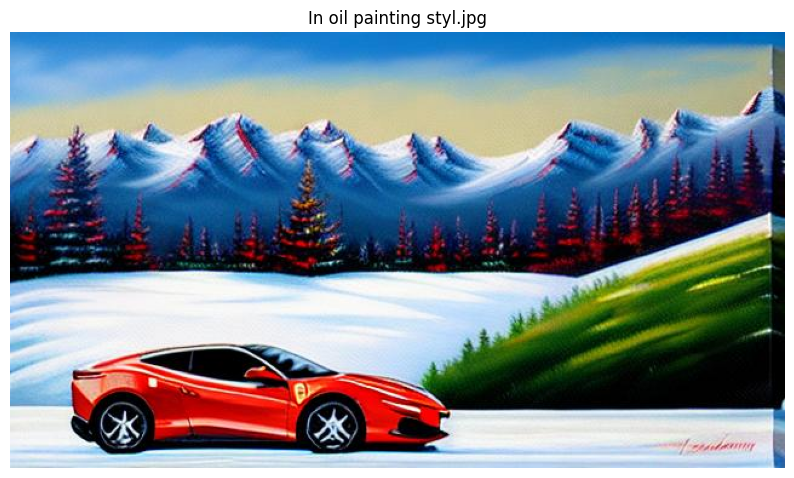

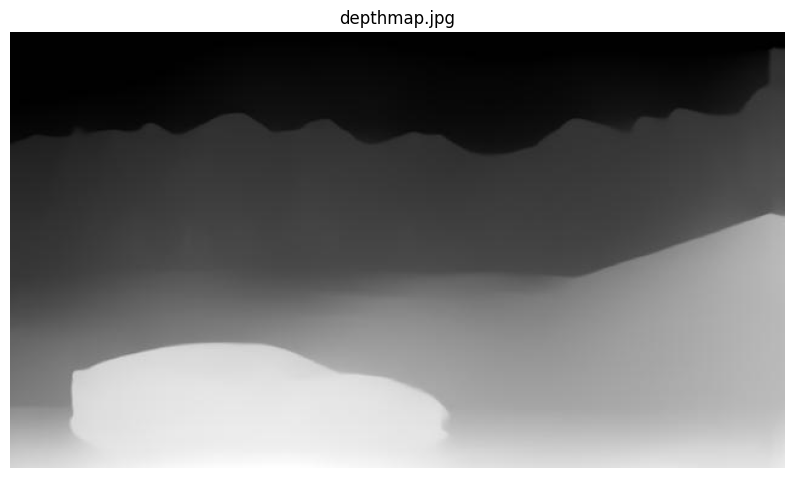

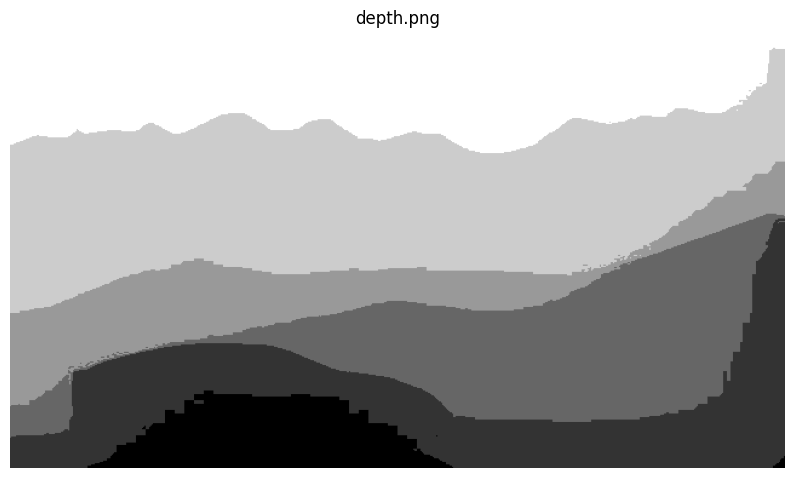

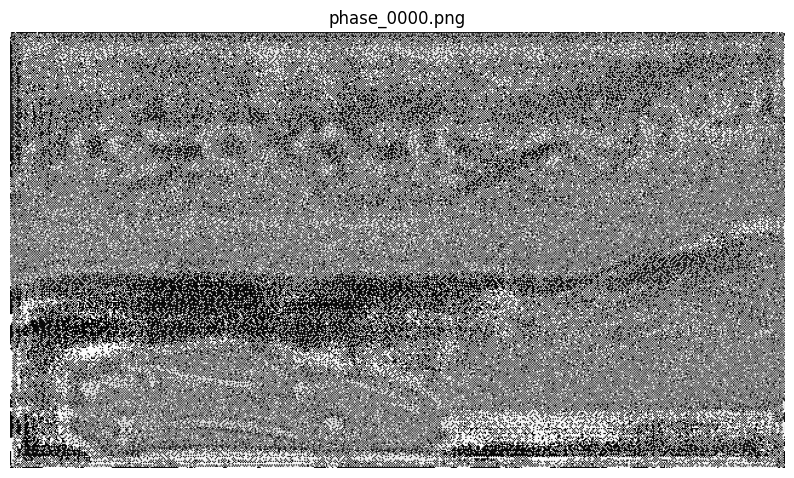

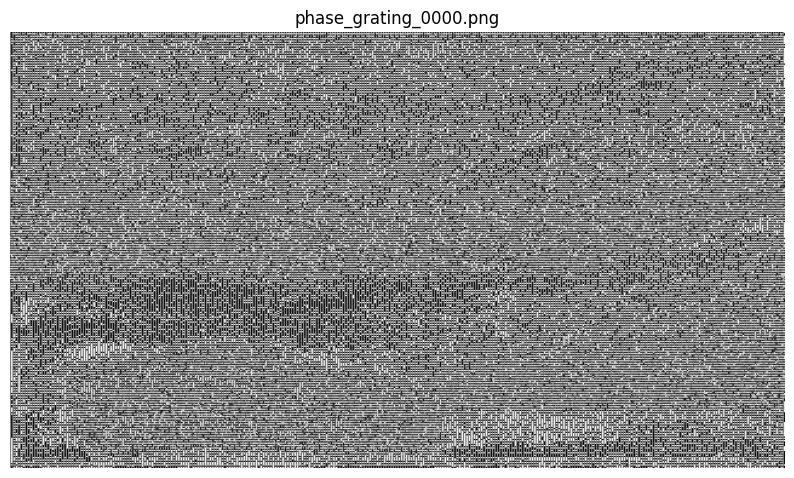

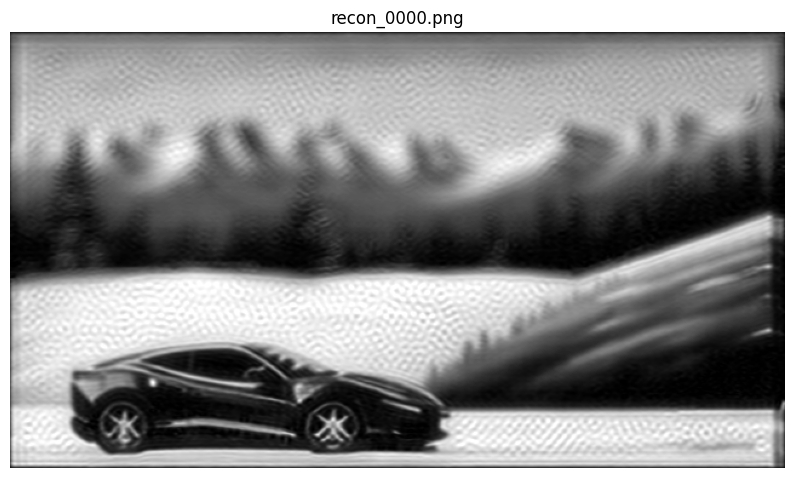

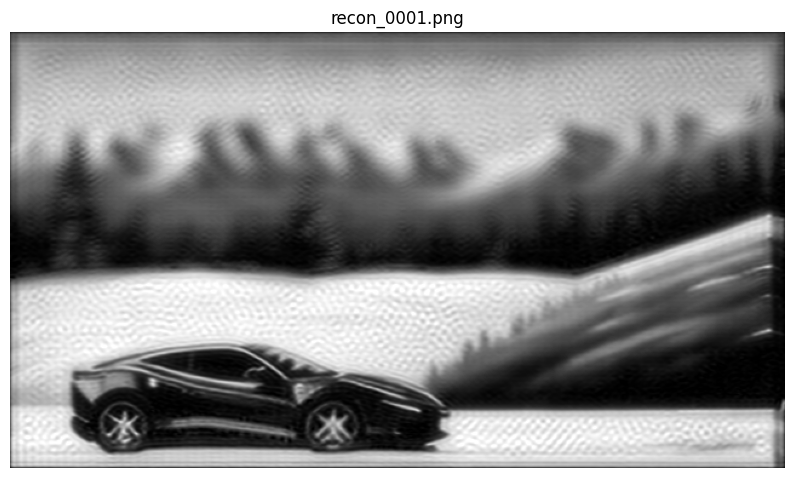

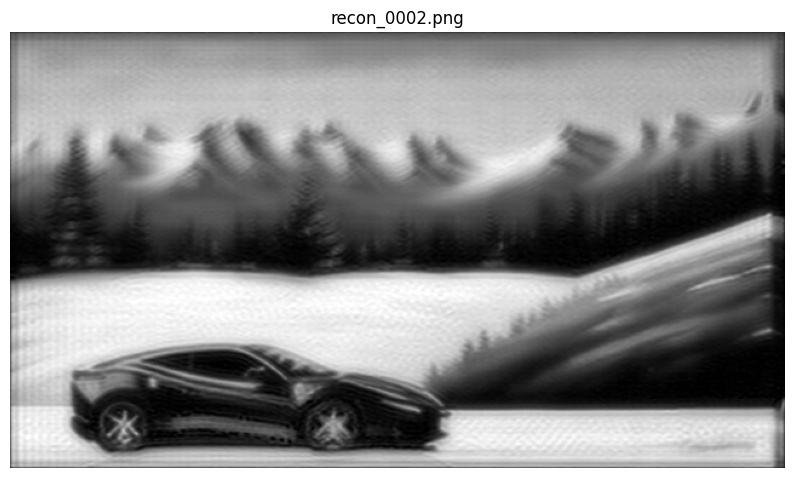

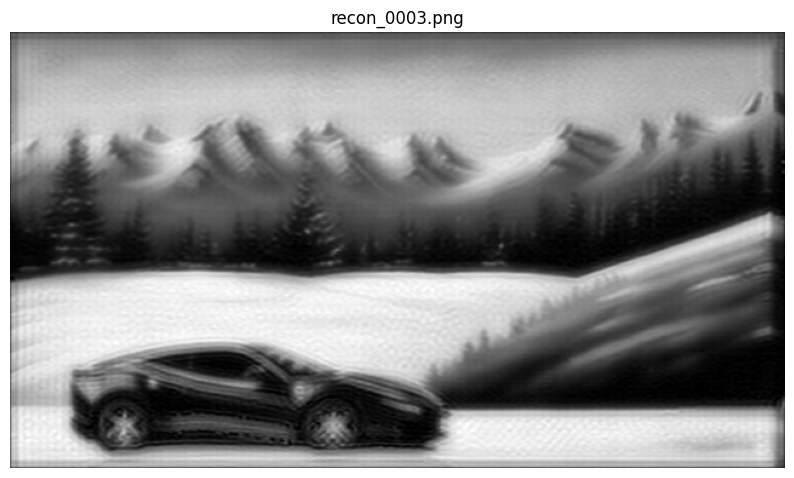

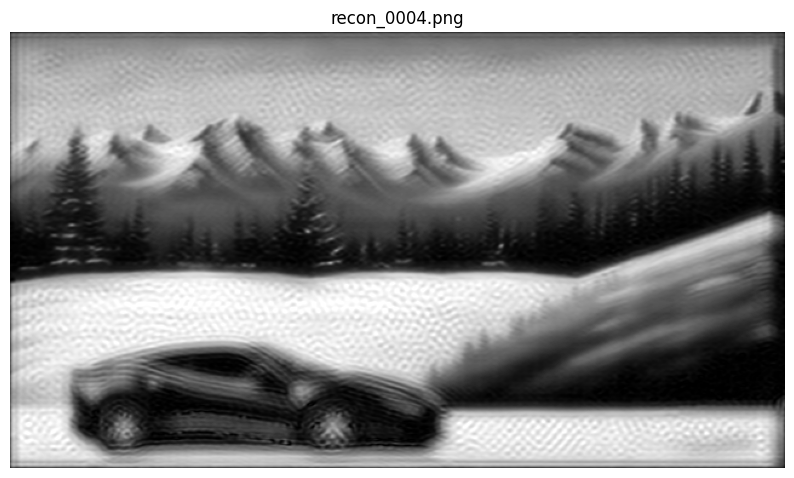

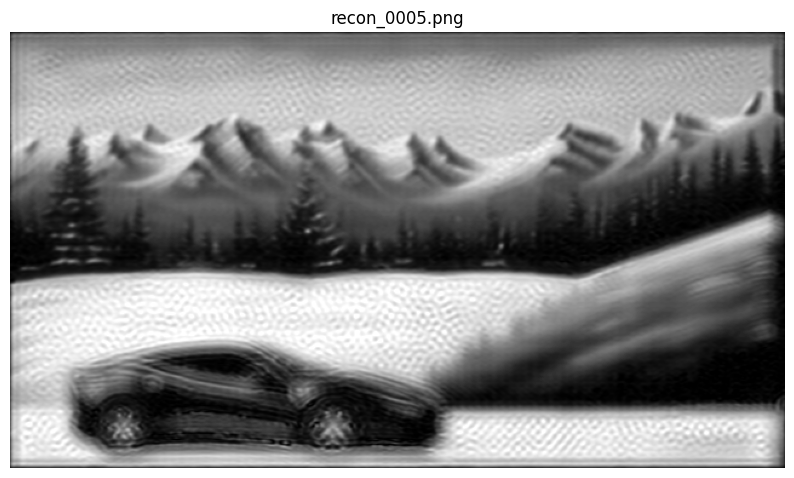

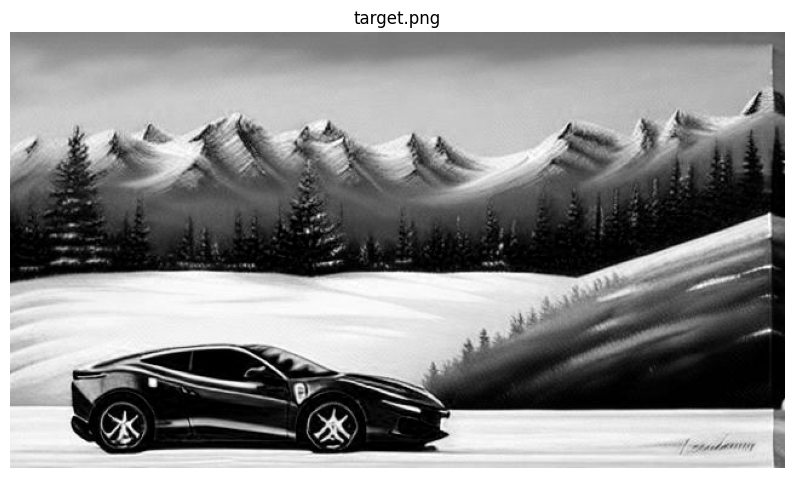

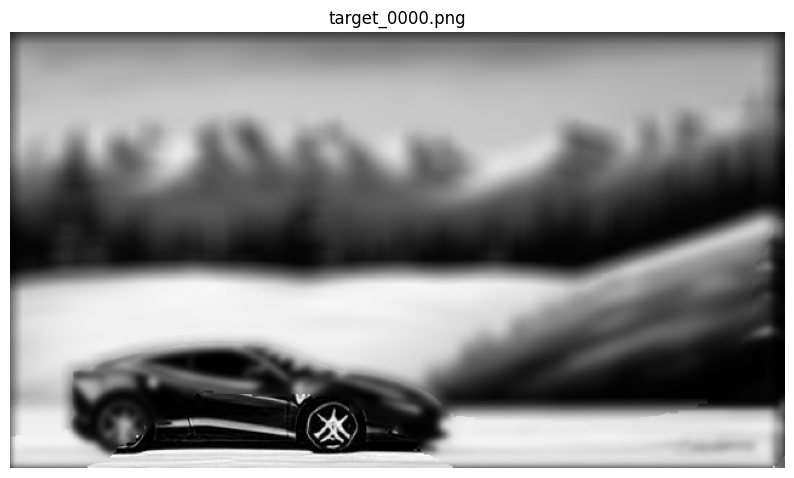

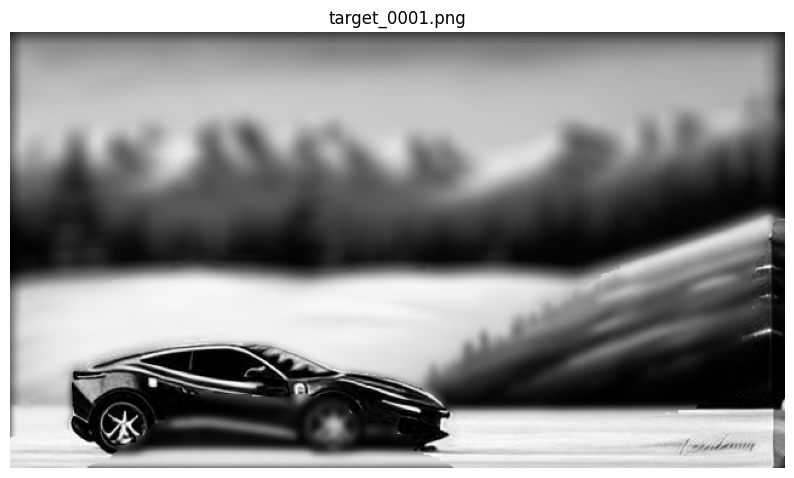

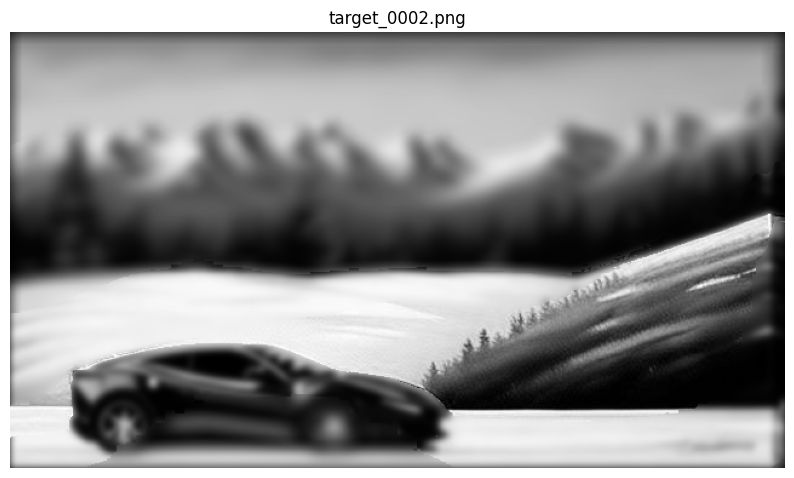

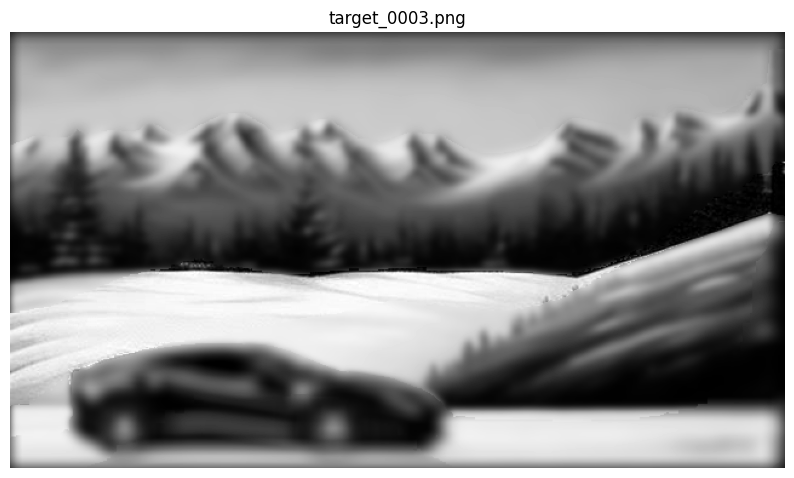

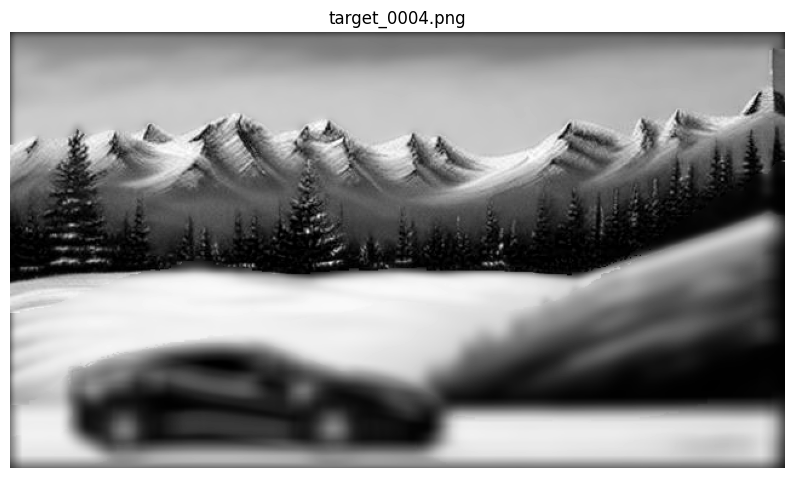

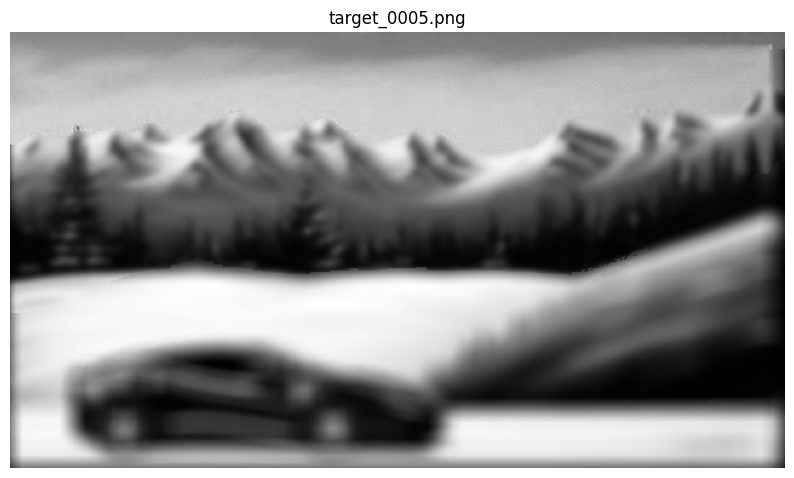

In [9]:
# Get user input for the sentence to base the image creation on
prompt = "In oil painting style, a ferrari car is on the snow-capped mountains." #@param {type:"string"}
inference_steps = 25 # @param {type:"integer"}
output_directory = "Output/" # @param {type:"string"}
settings = {

    "general": {
        "device": "cuda",
        "iterations": 60,
        "propagation type": "Bandlimited Angular Spectrum",
        "output directory": "Output/",
        "learning rate": 0.04,
        "hologram number": 1
    },
    "diffusion": {
        "inference_steps": inference_steps
    },
    "target": {
        "depth filename": "depthmap.jpg",
        "scheme": "defocus",
        "color channel": 1,
        "defocus blur size": 20,
        "blur ratio": 3,
        "number of planes": 6,
        "mask limits": [0.0, 1.0, 0.0, 1.0],
        "multiplier": 1.0,
        "weights": [1.0, 1.0, 1.0, 0.0]
    },
    "image": {
        "location": 0.0,
        "delta": 0.001,
        "zero mode distance": 0.3
    },
    "slm": {
        "model": "Jasper Display Educational 4k",
        "pixel pitch": 0.000008,
        "resolution": [360, 640]
    },
    "beam": {
        "wavelength": 0.000000515
    }
}



# Generate images
image_name, images = generate_images(pipe, prompt, settings, device)

# Process the depth map
process_depth_map(midas, transform, np.array(images[0]), device, settings)

# Perform CGH
cgh(settings, image_name)

clear_output()
display_images_from_directory('./'+output_directory)
display_images_from_directory('./'+output_directory,ext='.png')